In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pprint import pprint
from warnings import filterwarnings

filterwarnings("ignore", category=FutureWarning)

# EDA

In [9]:

data = pd.read_csv( "train.csv")
# external_data = pd.read_csv("../input/dfghdfgdfh/churn.csv")
X_test = pd.read_csv("test.csv")
# X_test.head()

In [13]:
data = data.drop_duplicates()

In [14]:
num_cols = [
    "ClientPeriod",
    "MonthlySpending",
    "TotalSpent",
]

cat_cols = [
    "Sex",
    "IsSeniorCitizen",
    "HasPartner",
    "HasChild",
    "HasPhoneService",
    "HasMultiplePhoneNumbers",
    "HasInternetService",
    "HasOnlineSecurityService",
    "HasOnlineBackup",
    "HasDeviceProtection",
    "HasTechSupportAccess",
    "HasOnlineTV",
    "HasMovieSubscription",
    "HasContractPhone",
    "IsBillingPaperless",
    "PaymentMethod",
]

target = 'Churn'


In [15]:
data.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')

In [16]:
data[data.drop(target, axis=1).duplicated(keep=False)].sort_values(by=[*data.columns])

ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
838              1            19.65      19.65  Female                0   
4811             1            19.65      19.65  Female                0   
3463             1            19.75      19.75    Male                0   
4294             1            19.75      19.75    Male                0   
3831             1            20.00         20    Male                0   
1647             1            20.00         20    Male                0   
3735             1            20.20       20.2    Male                0   
3769             1            20.20       20.2    Male                0   
881              1            20.40       20.4  Female                0   
1874             1            20.40       20.4  Female                0   
3239             1            20.50       20.5  Female                0   
1677             1            20.50       20.5  Female                0   
4735             1            20.90       20.9  Female                0   
2024             1            20.90       20.9  Female                0   
1040             1            45.40       45.4  Female                0   
5066             1            45.40       45.4  Female                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
838          No       No             Yes                      No   
4811         No       No             Yes                      No   
3463         No       No             Yes                      No   
4294         No       No             Yes                      No   
3831         No       No             Yes                      No   
1647         No       No             Yes                      No   
3735         No       No             Yes                      No   
3769         No       No             Yes                      No   
881          No       No             Yes                      No   
1874         No       No             Yes                      No   
3239         No       No             Yes                      No   
1677         No       No             Yes                      No   
4735         No       No             Yes                      No   
2024         No       No             Yes                      No   
1040         No       No             Yes                      No   
5066         No       No             Yes                      No   

     HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
838                  No      No internet service  No internet service   
4811                 No      No internet service  No internet service   
3463                 No      No internet service  No internet service   
4294                 No      No internet service  No internet service   
3831                 No      No internet service  No internet service   
1647                 No      No internet service  No internet service   
3735                 No      No internet service  No internet service   
3769                 No      No internet service  No internet service   
881                  No      No internet service  No internet service   
1874                 No      No internet service  No internet service   
3239                 No      No internet service  No internet service   
1677                 No      No internet service  No internet service   
4735                 No      No internet service  No internet service   
2024                 No      No internet service  No internet service   
1040                DSL                       No                   No   
5066                DSL                       No                   No   

      HasDeviceProtection HasTechSupportAccess          HasOnlineTV  \
838   No internet service  No internet service  No internet service   
4811  No internet service  No internet service  No internet service   
3463  No internet service  No internet service  No internet service   
4294  No internet service  No internet service 

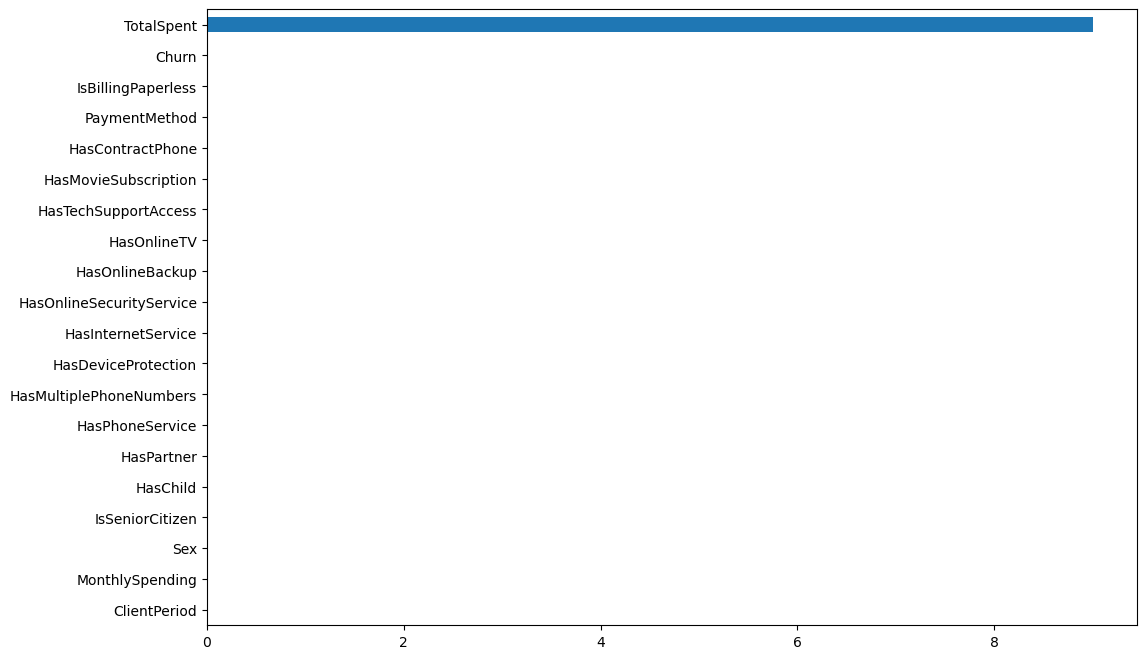

In [18]:
data.replace(" ", np.nan, inplace=True)
X_test.replace(" ", np.nan, inplace=True)
pd.DataFrame(data.isna().sum(), columns=["NaN Count"]) \
    .sort_values("NaN Count") \
    .plot(kind="barh", legend=False, figsize=(12, 8));

We have 9 NaN's in TotalSpent column. Let's take a closer look at these clients.

In [19]:
data.sort_values("TotalSpent").tail(10)

ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
1157            11            94.20      999.9  Female                0   
1048             0            25.75        NaN    Male                0   
1707             0            73.35        NaN  Female                0   
2543             0            19.70        NaN    Male                0   
3078             0            80.85        NaN  Female                0   
3697             0            20.00        NaN  Female                0   
4002             0            61.90        NaN    Male                0   
4326             0            25.35        NaN    Male                0   
4551             0            52.55        NaN  Female                0   
4598             0            56.05        NaN  Female                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
1157         No       No             Yes                      No   
1048        Yes      Yes             Yes                     Yes   
1707        Yes      Yes             Yes                     Yes   
2543        Yes      Yes             Yes                      No   
3078        Yes      Yes             Yes                      No   
3697        Yes      Yes             Yes                      No   
4002         No      Yes             Yes                     Yes   
4326        Yes      Yes             Yes                     Yes   
4551        Yes      Yes              No        No phone service   
4598        Yes      Yes              No        No phone service   

     HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
1157        Fiber optic                       No                  Yes   
1048                 No      No internet service  No internet service   
1707                DSL                       No                  Yes   
2543                 No      No internet service  No internet service   
3078                DSL                      Yes                  Yes   
3697                 No      No internet service  No internet service   
4002                DSL                      Yes                  Yes   
4326                 No      No internet service  No internet service   
4551                DSL                      Yes                   No   
4598                DSL                      Yes                  Yes   

      HasDeviceProtection HasTechSupportAccess          HasOnlineTV  \
1157                  Yes                  Yes                   No   
1048  No internet service  No internet service  No internet service   
1707                  Yes                  Yes                  Yes   
2543  No internet service  No internet service  No internet service   
3078                  Yes                   No                  Yes   
3697  No internet service  No internet service  No internet service   
4002                   No                  Yes                   No   
4326  No internet service  No internet service  No internet service   
4551                  Yes                  Yes                  Yes   
4598                  Yes                  Yes                  Yes   

     HasMovieSubscription HasContractPhone IsBillingPaperless  \
1157                  Yes   Month-to-month                Yes   
1048  No internet service         Two year                 No   
1707                   No         Two year                 No   
2543  No internet service         One year                Yes   
3078                  Yes         Two year                 No   
3697  No internet service         Two year                 No   
4002                   No         Two year                Yes   
4326  No internet service         Two year                 No   
4551                   No         Two year                Yes   
4598                   No         Two year                 No   

                  PaymentMethod  Churn  
1157           Electronic check      0  
1048               Mailed check      0  
1707  

Obviously it's new clients who did not make first payment yet. Let's fill them with zeroes.

In [20]:
data["TotalSpent"] = data.TotalSpent.fillna(0).astype(float)
X_test["TotalSpent"] = X_test.TotalSpent.fillna(0).astype(float)

In [21]:
patterns = {
    "No": 0,
    "No internet service": 0,
    "No phone service": 0,
    "Yes": 1,
    "Male": 0,
    "Female": 1,
    "DSL": 1,
    "Fiber optic": 2,
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2,
    "Credit card (automatic)": 0,
    "Bank transfer (automatic)": 1,
    "Mailed check": 2,
    "Electronic check": 3,
}
X_train = data.replace(patterns).drop(target, axis=1)
y_train = data[target]
X_test = X_test.replace(patterns)

It makes possible to draw correlation heatmap.

In [22]:
sns.heatmap(data=pd.concat([X_train, y_train], axis=1).corr(),
            annot=True,
            cmap="coolwarm",
            center=0,
            ax=plt.subplots(figsize=(15,10))[1]);

HasContractPhone has strongest correlation with target (-0.4), then goes ClientPeriod(-0.35), and HasInternetService (0.31). In first two cases correlation is negative. It's positive in the last. It's tempting to think that provider gained very loyal phone users over the years, then decided to go to internet market and didn't do so well...

Let's evaluate feature importance with RandomForest.

In [23]:
clf = RandomForestClassifier(n_estimators=2000, min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["importance"]) \
    .sort_values("importance") \
    .plot(kind="barh", legend=False, figsize=(12, 8));
plt.title("Feature importance");

The chart confirms our observations.

Now let's do the same with a single DecisionTree.

In [24]:
clf = DecisionTreeClassifier(min_impurity_decrease=0.002)
clf.fit(X_train, y_train)
plt.figure(figsize=(20, 8))
plot_tree(clf, fontsize=14, feature_names=X_train.columns, filled=True)
plt.show()

Let's look at explained variance ratio.

In [25]:
X_train_std = StandardScaler().fit_transform(X_train)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align="center", label="Individual explained variance")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.show()

# Logistic Regression

I've commented out param ranges to save time and left only optimal one.

In [26]:
%%time
PARAMS = {
    "model__C": [1.92],  # np.arange(0.001, 100, 0.001)
}
clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty="l1", solver="saga", max_iter=1000, random_state=42)),
])
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10,
    refit=True,
)
logreg = grid_search.fit(X_train, y_train)

CPU times: user 353 ms, sys: 109 ms, total: 462 ms
Wall time: 2.8 s


In [27]:
print(f"best score: {logreg.best_score_}")
print(f"best params: {logreg.best_params_}")

best score: 0.8446424877835602
best params: {'model__C': 1.92}


In [30]:
submission = pd.read_csv("submission.csv")
submission["Churn"] = logreg.predict_proba(X_test)[:, 1]
submission.to_csv("logreg.csv", index=False)

# CatBoost

In [31]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=42,
    loss_function='CrossEntropy',
#     task_type='GPU',
    early_stopping_rounds=10
)

PARAMS = {
    "n_estimators": [300, 500, 700, 1000],  # [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.05],  # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth": [4],  # np.arange(4, 20, 1),
    "l2_leaf_reg": [10],  # np.arange(0.1, 1, 0.05),
    "subsample": [0.6],  # [3, 5, 7, 10],
#     "random_strength": [2, 5, 8],  # [1, 2, 5, 10, 20, 50, 100],
    "min_data_in_leaf": [100],  # np.arange(10, 1001, 10),
#     'task_type': ['GPU'],
#     'early_stopping_rounds': [10],
}
catboost.grid_search(PARAMS, X_train, y_train, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8613374	best: 0.8613374 (0)	total: 253ms	remaining: 758ms
1:	loss: 0.8613374	best: 0.8613374 (0)	total: 394ms	remaining: 394ms


2:	loss: 0.8613374	best: 0.8613374 (0)	total: 548ms	remaining: 183ms
3:	loss: 0.8613374	best: 0.8613374 (0)	total: 681ms	remaining: 0us
Estimating final quality...


{'params': {'subsample': 0.6,
  'min_data_in_leaf': 100,
  'depth': 4,
  'learning_rate': 0.05,
  'l2_leaf_reg': 10,
  'iterations': 300},
 'cv_results': defaultdict(list,
             {'iterations': [0, 159],
              'test-AUC-mean': [0.7594245290659082, 0.7722085587502312],
              'test-AUC-std': [0.0329952960693606, 0.0547306140036087],
              'train-AUC-mean': [0.7694406509067567, nan],
              'train-AUC-std': [0.021178572633642437, nan],
              'test-CrossEntropy-mean': [0.6674084872897094, nan],
              'test-CrossEntropy-std': [0.0015408866045045968, nan],
              'train-CrossEntropy-mean': [0.6669548228025984, nan],
              'train-CrossEntropy-std': [0.0010061833249092238, nan]})}

In [32]:
print("Best score:", end=' ')
pprint(catboost.best_score_)
best_params = catboost.get_params()
for f in ("cat_features", "logging_level", "eval_metric"):
    best_params.pop(f)
print("Best params:", end=' ')
pprint(best_params)

Best score: {'learn': {'AUC': 0.8741365995085186, 'CrossEntropy': 0.3786454982044153}}
Best params: {'depth': 4,
 'early_stopping_rounds': 10,
 'grow_policy': 'Lossguide',
 'iterations': 300,
 'l2_leaf_reg': 10,
 'learning_rate': 0.05,
 'loss_function': 'CrossEntropy',
 'metric_period': 1000,
 'min_data_in_leaf': 100,
 'random_seed': 42,
 'subsample': 0.6}


In [34]:
submission = pd.read_csv("submission.csv")
submission["Churn"] = catboost.predict_proba(X_test)[:, 1]
submission.to_csv("catboost.csv", index=False)

# KNN

In [35]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)
PARAMS = {
    "model__n_neighbors": [44],  # range(1, 100),
    "model__metric": ["manhattan"],  # ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan", "nan_euclidean"],
}

clf = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", KNeighborsClassifier()),
])
    
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10,
    refit=True,
)
knn = grid_search.fit(X_train, y_train)

In [36]:
print(f"best score: {knn.best_score_}")
print(f"best params: {knn.best_params_}")

best score: 0.833998830344545
best params: {'model__metric': 'manhattan', 'model__n_neighbors': 44}


In [38]:
submission = pd.read_csv("submission.csv")
submission["Churn"] = knn.predict_proba(X_test)[:, 1]
submission.to_csv("knn.csv", index=False)

# Random Forest

In [39]:
PARAMS = {
    "min_samples_split": [9],  # range(2, 200),
    "min_samples_leaf": [18],  # range(1, 200),
}
clf = RandomForestClassifier(n_estimators=200, random_state=42)

grid_search = GridSearchCV(clf, PARAMS, scoring="roc_auc", cv=5)
rf = grid_search.fit(X_train, y_train);

In [40]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.842663891781078
Best params: {'min_samples_leaf': 18, 'min_samples_split': 9}


In [41]:
submission = pd.read_csv("submission.csv")
submission["Churn"] = rf.predict_proba(X_test)[:, 1]
submission.to_csv("rf.csv", index=False)

# Stacking

Finally let's create stacking ensemble from all these models.

In [42]:
meta = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1,
)
stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("knn", knn),
        ("rf", rf),
        ("catboost", catboost),
    ],
    final_estimator=meta,
    n_jobs=-1,
)

stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('logreg',
                                GridSearchCV(cv=10,
                                             estimator=Pipeline(steps=[('scaler',
                                                                        StandardScaler()),
                                                                       ('model',
                                                                        LogisticRegression(max_iter=1000,
                                                                                           penalty='l1',
                                                                                           random_state=42,
                                                                                           solver='saga'))]),
                                             n_jobs=-1,
                                             param_grid={'model__C': [1.92]},
                                             scoring='roc_auc')),
                               ('knn',
                                GridSearchCV(cv=10,
                                             estimator=Pipeline(steps=[('preproc',
                                                                        ColumnTransformer(trans...
                                                         'model__n_neighbors': [44]},
                                             scoring='roc_auc')),
                               ('rf',
                                GridSearchCV(cv=5,
                                             estimator=RandomForestClassifier(n_estimators=200,
                                                                              random_state=42),
                                             param_grid={'min_samples_leaf': [18],
                                                         'min_samples_split': [9]},
                                             scoring='roc_auc')),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7f7ae85ba0a0>)],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7f7b1e651970>,
                   n_jobs=-1)

# Final Prediction

In [43]:
best_model = stacking

In [45]:
y_pred = best_model.predict_proba(X_test)[:, 1]
submission = pd.read_csv("./submission.csv")
submission['Churn'] = y_pred
submission.to_csv("submission.csv", index=False)